In [1]:
from pathlib import Path
import anndata as ad
import pandas as pd
import pyensembl
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
import numpy as np

from portraits.utils import read_gene_sets, ssgsea_formula, median_scale
from portraits.clustering import clustering_profile_metrics, clustering_profile_metrics_plot, clustering_select_best_tr

def get_notebook_logger(name=__name__):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    
    # Avoid duplicate handlers if the cell is run multiple times
    if not logger.handlers:
        # StreamHandler(sys.stdout) ensures it prints to the cell
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(logging.INFO)
        
        formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        
        logger.addHandler(handler)
    
    # Prevent logs from double-printing if the root logger is also active
    logger.propagate = False
    return logger

logger = get_notebook_logger("Clustering")
logger.info("Logger is ready!")

Clustering - INFO - Logger is ready!


In [6]:
adata = ad.read("../lair/ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized/Gide.h5ad")

/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata.obs

,age,sex,primary_tumor,overall_survival,response,RECIST,prior_CTLA4,prior_PD1,treatment.CTLA4,treatment.PD1,...,treatment.KIR,treatment.CD137,treatment.IDO,treatment.LAG-3,treatment.ACT,treatment.CYTOSTASIS,timing,sample_source,original.patient_id,original.sample_id
0,90,male,SKMC,551,NR,PD,False,False,False,True,...,False,False,False,False,False,False,Post,NaN,10,10_PD1_EDT
1,90,male,SKMC,551,NR,PD,False,False,False,True,...,False,False,False,False,False,False,Pre,NaN,10,10_PD1_PRE
2,51,male,SKMC,176,NR,PD,False,False,True,True,...,False,False,False,False,False,False,Pre,NaN,10,10_ipiPD1_PRE
3,66,male,SKMC,166,NR,PD,False,False,False,True,...,False,False,False,False,False,False,Pre,NaN,11,11_PD1_PRE
4,52,male,SKMC,199,NR,SD,False,False,False,True,...,False,False,False,False,False,False,Pre,NaN,12,12_PD1_PRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,59,male,SKMC,169,R,PR,False,False,True,True,...,False,False,False,False,False,False,Pre,NaN,7,7_ipiPD1_PRE
85,85,female,SKMC,58,NR,PD,False,False,False,True,...,False,False,False,False,False,False,Post,NaN,8,8_PD1_EDT
86,85,female,SKMC,58,NR,PD,False,False,False,True,...,False,False,False,False,False,False,Pre,NaN,8,8_PD1_PRE
87,55,male,SKMC,637,NR,PD,False,False,True,True,...,False,False,False,False,False,False,Pre,NaN,8,8_ipiPD1_PRE


../lair/TCGA-AllProjectsAdata/SKCM.h5ad
Clustering - INFO - Transposing adata!
Clustering - INFO - Read 29 gene sets from:
	/Users/halu/Code/MFP/signatures/gene_signatures.gmt


/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
100%|██████████| 35/35 [00:16<00:00,  2.12it/s]
/Users/halu/Code/MFP/portraits/clustering.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_scs_filtered.sc += 1 - cl_scs_filtered.sc.min()


MFP
F       208
IE      142
IE/F     81
D        41
Name: count, dtype: int64


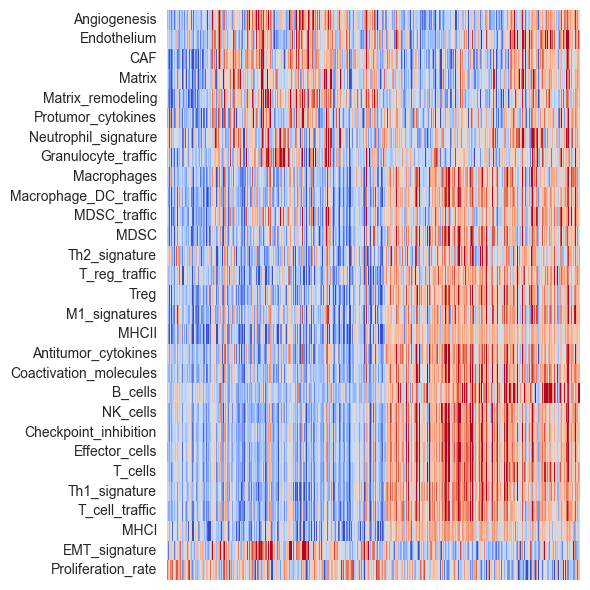

In [12]:
def detect_type(clustering_metrics: pd.DataFrame,scores: pd.DataFrame) -> pd.Series:

    clusters_number = clustering_metrics.loc['N'] 

    # samples_clustering is a pd.Series with patients as indexes and their clusters as values
    samples_clustering = clustering_metrics.loc['perc']
    cluster_means = pd.DataFrame({cluster: scores.loc[samples_clustering[samples_clustering == cluster].index].mean()
                                  for cluster in range(1, clusters_number + 1)})

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling']].mean() -
              cluster_means.loc[['MHCII', 'Antitumor_cytokines', 'Coactivation_molecules',
                          'B_cells', 'NK_cells', 'Checkpoint_inhibition',
                          'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI']].mean()).sort_values()

    mapper = {}
    mapper[deltas.index[-1]] = 'F'  # The cluster with the highest fibrose value is classified as Fibrotic
    mapper[deltas.index[0]] = 'IE'  # Thecluster with the highest level of immune cells is classified as 
                                    # Immune enriched, non-fibrotic

    # Remove detected clusters
    cluster_means.pop(deltas.index[-1])
    cluster_means.pop(deltas.index[0])

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling',
                          'Protumor_cytokines', 'Neutrophil_signature', 'Granulocyte_traffic',
                          'Macrophages', 'Macrophage_DC_traffic', 'MDSC_traffic', 'MDSC',
                          'Th2_signature', 'T_reg_traffic', 'Treg', 'M1_signatures', 'MHCII',
                          'Antitumor_cytokines', 'Coactivation_molecules', 'B_cells', 'NK_cells',
                          'Checkpoint_inhibition', 'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI', 'EMT_signature']].mean() -
              cluster_means.loc['Proliferation_rate']).sort_values()

    mapper[deltas.index[0]] = 'D'  # The cluster with the highest proliferation value 
                                   # is classified as (Immune) Desert

    mapper[deltas.index[-1]] = 'IE/F'  # Every sample not falling into the above-mentioned 
                                       # categories is classified as Immune enriched - fibrotic

    return samples_clustering.map(mapper).rename('MFP')

def gene_id_to_name(gene_id, ensembl):
    try:
        name = ensembl.gene_by_id(gene_id.split(".")[0]).name
        if name == "" or name[-5:] == "_rRNA" or name == "7SK":
            return None
        return name
    except:
        return None

def df_gene_id_to_name(df):
    ensembl = pyensembl.EnsemblRelease(111, "human")
    genes = pd.DataFrame(
        {"name": [gene_id_to_name(gene_id, ensembl) for gene_id in df.columns]},
        index=df.columns
    ).sort_values("name")
    
    df = df[genes.dropna().index]
    df.columns = genes.dropna().name
    return df

def get_signature(df):
    signatures_dir = Path("../signatures").resolve()
    assert signatures_dir.exists() and signatures_dir.is_dir()
    gmt = read_gene_sets(signatures_dir.joinpath('gene_signatures.gmt'))
    logger.info(f"Read {len(gmt)} gene sets from:\n\t{signatures_dir.joinpath('gene_signatures.gmt')}")
    signature_scores = ssgsea_formula(np.log2(df), gmt)
    gene_signatures = pd.read_csv(signatures_dir / "gene_signatures_order.tsv", sep="\t", header=None)
    signature_scores = signature_scores[[x[0] for x in gene_signatures.values]]
    signature_scores_scaled = median_scale(signature_scores)
    return signature_scores_scaled

def cluster(signature_scores_scaled):
    clustering_metrics, best_threshold = clustering_select_best_tr(signature_scores_scaled, method="louvain",
                                                                   threshold_mm=(.3, .65), step=.01, plot=False)
    ordered_classified_samples = detect_type(clustering_metrics.loc[best_threshold], signature_scores_scaled)
    ordered_classified_samples = ordered_classified_samples.sort_values()
    print(ordered_classified_samples.value_counts())
    return ordered_classified_samples


def plot_heatmap(signature_scores_scaled, ordered_classified_samples):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(
        signature_scores_scaled.loc[ordered_classified_samples.sort_values().index].clip(-2, 2).T,
        yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm,ax=ax
    )
    ax.axvspan(-2, -4, color='red', alpha=0.3)
    plt.tight_layout()
    return fig
    

def make_signatures_and_classification(df):
    df = df_gene_id_to_name(df)
    signature_scores_scaled = get_signature(df)
    ordered_classified_samples = cluster(signature_scores_scaled)
    return signature_scores_scaled, ordered_classified_samples

def make_heatmap_and_classification_from_tcga_file(file, transpose=True, sample=0):
    print(file)
    adata = ad.read_h5ad(file)
    if transpose:
        logger.info("Transposing adata!")
        adata = adata.T
    df = adata.to_df()
    if isinstance(sample, int) and sample >= 0:
        logger.info("Sampling = {}".format(sample))
        sample = min(sample, len(df))
        df = df.sample(sample, random_state=0)
    try:
        signature_scores_scaled, ordered_classified_samples = make_signatures_and_classification(df)
        fig = plot_heatmap(signature_scores_scaled, ordered_classified_samples)
    except Exception as e:
        logger.error(f"Error processing {file}: {e}")
        fig, ax = plt.subplots()
        signature_scores_scaled = pd.DataFrame()
        ordered_classified_samples = pd.DataFrame()
    return fig, ordered_classified_samples, signature_scores_scaled

def assert_exist_and_dir(paths):
    for path in paths:
        assert path.exists() and path.is_dir(), path

def main():
    lair_path = Path("../lair")
    data_path = lair_path / "TCGA-AllProjectsAdata"
    #data_path = lair_path / "ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized"
    plot_dir = Path("../plots/heatmaps").joinpath(data_path.name)
    data_out_dir = Path("../data").joinpath(data_path.name)
    assert_exist_and_dir([lair_path, data_path, plot_dir, data_out_dir])
    
    transpose = True if data_path.name == "TCGA-AllProjectsAdata" else False
    for file in sorted(list(data_path.glob("*.h5ad"))):
        if file.stem != "SKCM":
            continue
        fig, ordered_classified_samples, signature_scores_scaled = make_heatmap_and_classification_from_tcga_file(file, transpose, sample=None)
        fig.savefig(plot_dir.joinpath("{}.svg".format(file.stem)))
        signature_scores_scaled.to_csv(data_out_dir.joinpath("signature_scores_scaled/{}.csv".format(file.stem)))
        ordered_classified_samples.to_csv(data_out_dir.joinpath("ordered_classified_samples/{}.csv".format(file.stem)))

main()

In [157]:
import anndata as ad

lair_path = Path("../lair")
data_path = lair_path / "ImmuneCheckpointTherapyResponseProcessedGeneNormalizedClinicalDataNormalized"

adatas = []
for file in sorted(list(data_path.glob("*.h5ad"))):
    adata = ad.read(file)
    adata.obs["study"] = file.stem
    adatas.append(adata)
adata = ad.concat(adatas)

adata.obs["primary_tumor"] = adata.obs["primary_tumor"].replace({"SKMC": "SKCM"})
adata.obs["response"] = adata.obs["response"].map({"NR": 0, "R": 1})
adata.obs["primary_tumor"] = adata.obs["primary_tumor"].replace({"SKCM": "SKCM"})


cancer_abbreviations = {
    "BLCA": "Bladder Urothelial Carc.",
    "HNSC": "Head & Neck Sq. Cell Carc.",
    "LUAD": "Lung Adenocarcinoma",
    "LUSC": "Lung Squamous Cell Carc.",
    "SKCM": "Skin Cutaneous Melanoma",
    "UVM": "Uveal Melanoma"
}
adata.obs["primary_tumor"] = adata.obs["primary_tumor"].map(cancer_abbreviations)

immunotherapy_studies = {
    "Auslander": "Auslander et al., 2018",
    "Chen": "Chen et al., 2016",
    "Freeman": "Freeman et al., 2000",
    "Gide": "Gide et al., 2019",
    "Hugo": "Hugo et al., 2016",
    "Lauss": "Lauss et al., 2017",
    "Liu": "Liu et al., 2019",
    "Prat": "Prat et al., 2017",
    "Ravi": "Ravi et al., 2018",
    "Riaz": "Riaz et al., 2017",
    "Rose": "Rose et al., 2021",
    "Snyder": "Snyder et al., 2014",
    "VanAllen": "VanAllen et al., 2015"
}
adata.obs["study"] = adata.obs["study"].map(immunotherapy_studies)
# Example usage:
# print(cancer_abbreviations["LUAD"])

/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/halu/miniconda3/envs/MFP/lib/python3.10/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read`

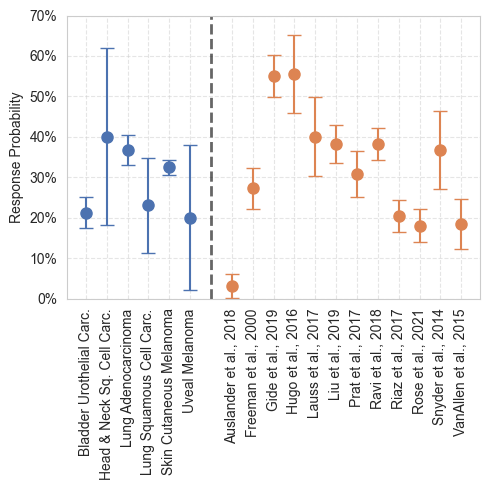

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Get the list of default colors
# "deep" is the standard, others include "muted", "bright", "pastel"
colors = sns.color_palette("deep")

def plot_response_rates(adata, features):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    current_pos = 0
    all_ticks = []
    all_labels = []
    gap = 2  # The space between the two feature sets
    
    for i, (feature, color) in enumerate(zip(features, colors)):
        # calculate stats
        counts = adata.obs.groupby(feature)["response"].value_counts(normalize=True).unstack()
        ns = adata.obs.groupby(feature).size()
        se = np.sqrt(counts[0] * counts[1] / ns)
        
        indices = np.arange(len(counts.index)) + current_pos

        ax.errorbar(
            x=indices,
            y=counts[1],
            yerr=se,
            fmt="o",
            capsize=5,
            markersize=8,
            color=color,
            ecolor=color,
            label=feature
        )
        
        # Store ticks and labels for the X-axis
        all_ticks.extend(indices)
        all_labels.extend(counts.index.astype(str))
        
        if i < len(features) - 1:
            sep_pos = indices[-1] + (gap / 2)
            ax.axvline(x=sep_pos, color='black', linestyle='--', linewidth=2, alpha=0.6)
            # Update starting position for next loop
            current_pos = indices[-1] + gap

    ax.set_xticks(all_ticks)
    ax.set_xticklabels(all_labels, rotation=90, ha='center')
    # ax.set_title('Response Rates by Feature (with SE)')
    ax.set_ylabel('Response Probability')
    ax.set_ylim(0, 0.7)
    ax.grid(axis='both', linestyle='--', alpha=0.5)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.legend()
    
    plt.tight_layout()
    plt.savefig("../plots/response-rates.svg")
    plt.show()

plot_response_rates(adata, ["primary_tumor", "study"])

In [168]:
adata.obs.RECIST.dropna().value_counts()["CR"]/adata.obs.RECIST.dropna().shape[0]

0.09863945578231292